##### Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import StandardScaler

In [2]:
DATA_TYPE = "DAILY" # Otions: "MONTHLY", "DAILY"

##### Data preprocessing

In [3]:
# Import Bank of England spot curve data from excel

if DATA_TYPE == "MONTHLY": 
    path1 = '/home/carlos/git_code/algotrading/fixed_income/glcnominalmonthedata/GLC Nominal month end data_1970 to 2015.xlsx'
    path2 = '/home/carlos/git_code/algotrading/fixed_income/glcnominalmonthedata/GLC Nominal month end data_2016 to present.xlsx'
    
    df = pd.read_excel(path1, index_col=0, header=3, sheet_name="4. spot curve", skiprows=[4])
    df2 = pd.read_excel(path2, index_col=0, header=3, sheet_name="4. spot curve", skiprows=[4])
    raw_dfs = [df, df2]
    df_raw = pd.concat(raw_dfs, axis=0)


elif DATA_TYPE == "DAILY":
    path_daily = '/home/carlos/git_code/algotrading/fixed_income/glcnominalddata/GLC Nominal daily data'
    daily_files = ['_1979 to 1984.xlsx', '_1985 to 1989.xlsx',
                '_1990 to 1994.xlsx', '_1995 to 1999.xlsx',
                '_2000 to 2004.xlsx', '_2005 to 2015.xlsx',
                '_2016 to present.xlsx']

    short_col_names = [i for i in range(1, 61)]
    
    short_dfs= []
    long_dfs= []
    for i in range(len(daily_files)):
        _df_s = pd.read_excel(path_daily+daily_files[i], index_col=0, header=None, sheet_name="1. nominal fwds, short end", skiprows=[0, 1, 2, 3, 4], names=short_col_names)
        _df_l = pd.read_excel(path_daily+daily_files[i], index_col=0, header=3, sheet_name="2. nominal fwd curve")
        
        short_dfs.append(_df_s)
        long_dfs.append(_df_l)
    
    short_df = pd.concat(short_dfs, axis=0)
    short_df.index.name = None
    
    long_df = pd.concat(long_dfs, axis=0)
    long_df.columns = [int(i*12) for i in long_df.columns]
    long_df.index.name = None
    
else:
    print("DATA_TYPE not recognised.")


In [4]:
if DATA_TYPE == "MONTHLY":

    df = df_raw.dropna(axis=0, how='all')
    df = df.dropna(axis=1, how='any')

else:
    
    short_df_clean = short_df.dropna(axis=0, how='all')
    short_df_clean = short_df_clean.dropna(axis=1, how='any')

    long_df_clean = long_df.dropna(axis=0, how='all')
    long_df_clean = long_df_clean.dropna(axis=1, how='any')
    
    cols_to_use = long_df_clean.columns.difference(short_df_clean.columns)
    df = pd.merge(short_df_clean, long_df_clean[cols_to_use], left_index=True, right_index=True, how='left')


In [5]:
df = df.dropna()
df.head()

,13,14,15,16,17,18,19,20,21,22,...,138,144,150,156,162,168,174,180,186,192
1979-01-02,12.160541,12.239510,12.313709,12.382672,12.445970,12.503654,12.556086,12.603636,12.646669,12.685556,...,12.188646,12.158287,12.141249,12.137681,12.147104,12.167908,12.198045,12.235337,12.277565,12.322653
1979-01-03,12.117373,12.198382,12.276247,12.349968,12.418612,12.481987,12.540340,12.593926,12.642999,12.687815,...,12.208385,12.177902,12.160921,12.157528,12.167204,12.188310,12.218786,12.256449,12.299081,12.344608
1979-01-04,12.037542,12.114271,12.188799,12.260063,12.327076,12.389602,12.447817,12.501900,12.552031,12.598390,...,12.192798,12.164760,12.151054,12.151672,12.165979,12.192152,12.227977,12.271148,12.319356,12.370463
1979-01-05,11.976759,12.053277,12.127746,12.199151,12.266584,12.329887,12.389211,12.444709,12.496536,12.544844,...,12.271212,12.237808,12.218177,12.212414,12.219975,12.239124,12.267727,12.303544,12.344315,12.387944
1979-01-08,11.903180,11.984597,12.064025,12.140255,12.212226,12.279755,12.342998,12.402109,12.457244,12.508558,...,12.272129,12.237448,12.216602,12.209686,12.216159,12.234270,12.261873,12.296716,12.336528,12.379203


##### Yield curve for last available date

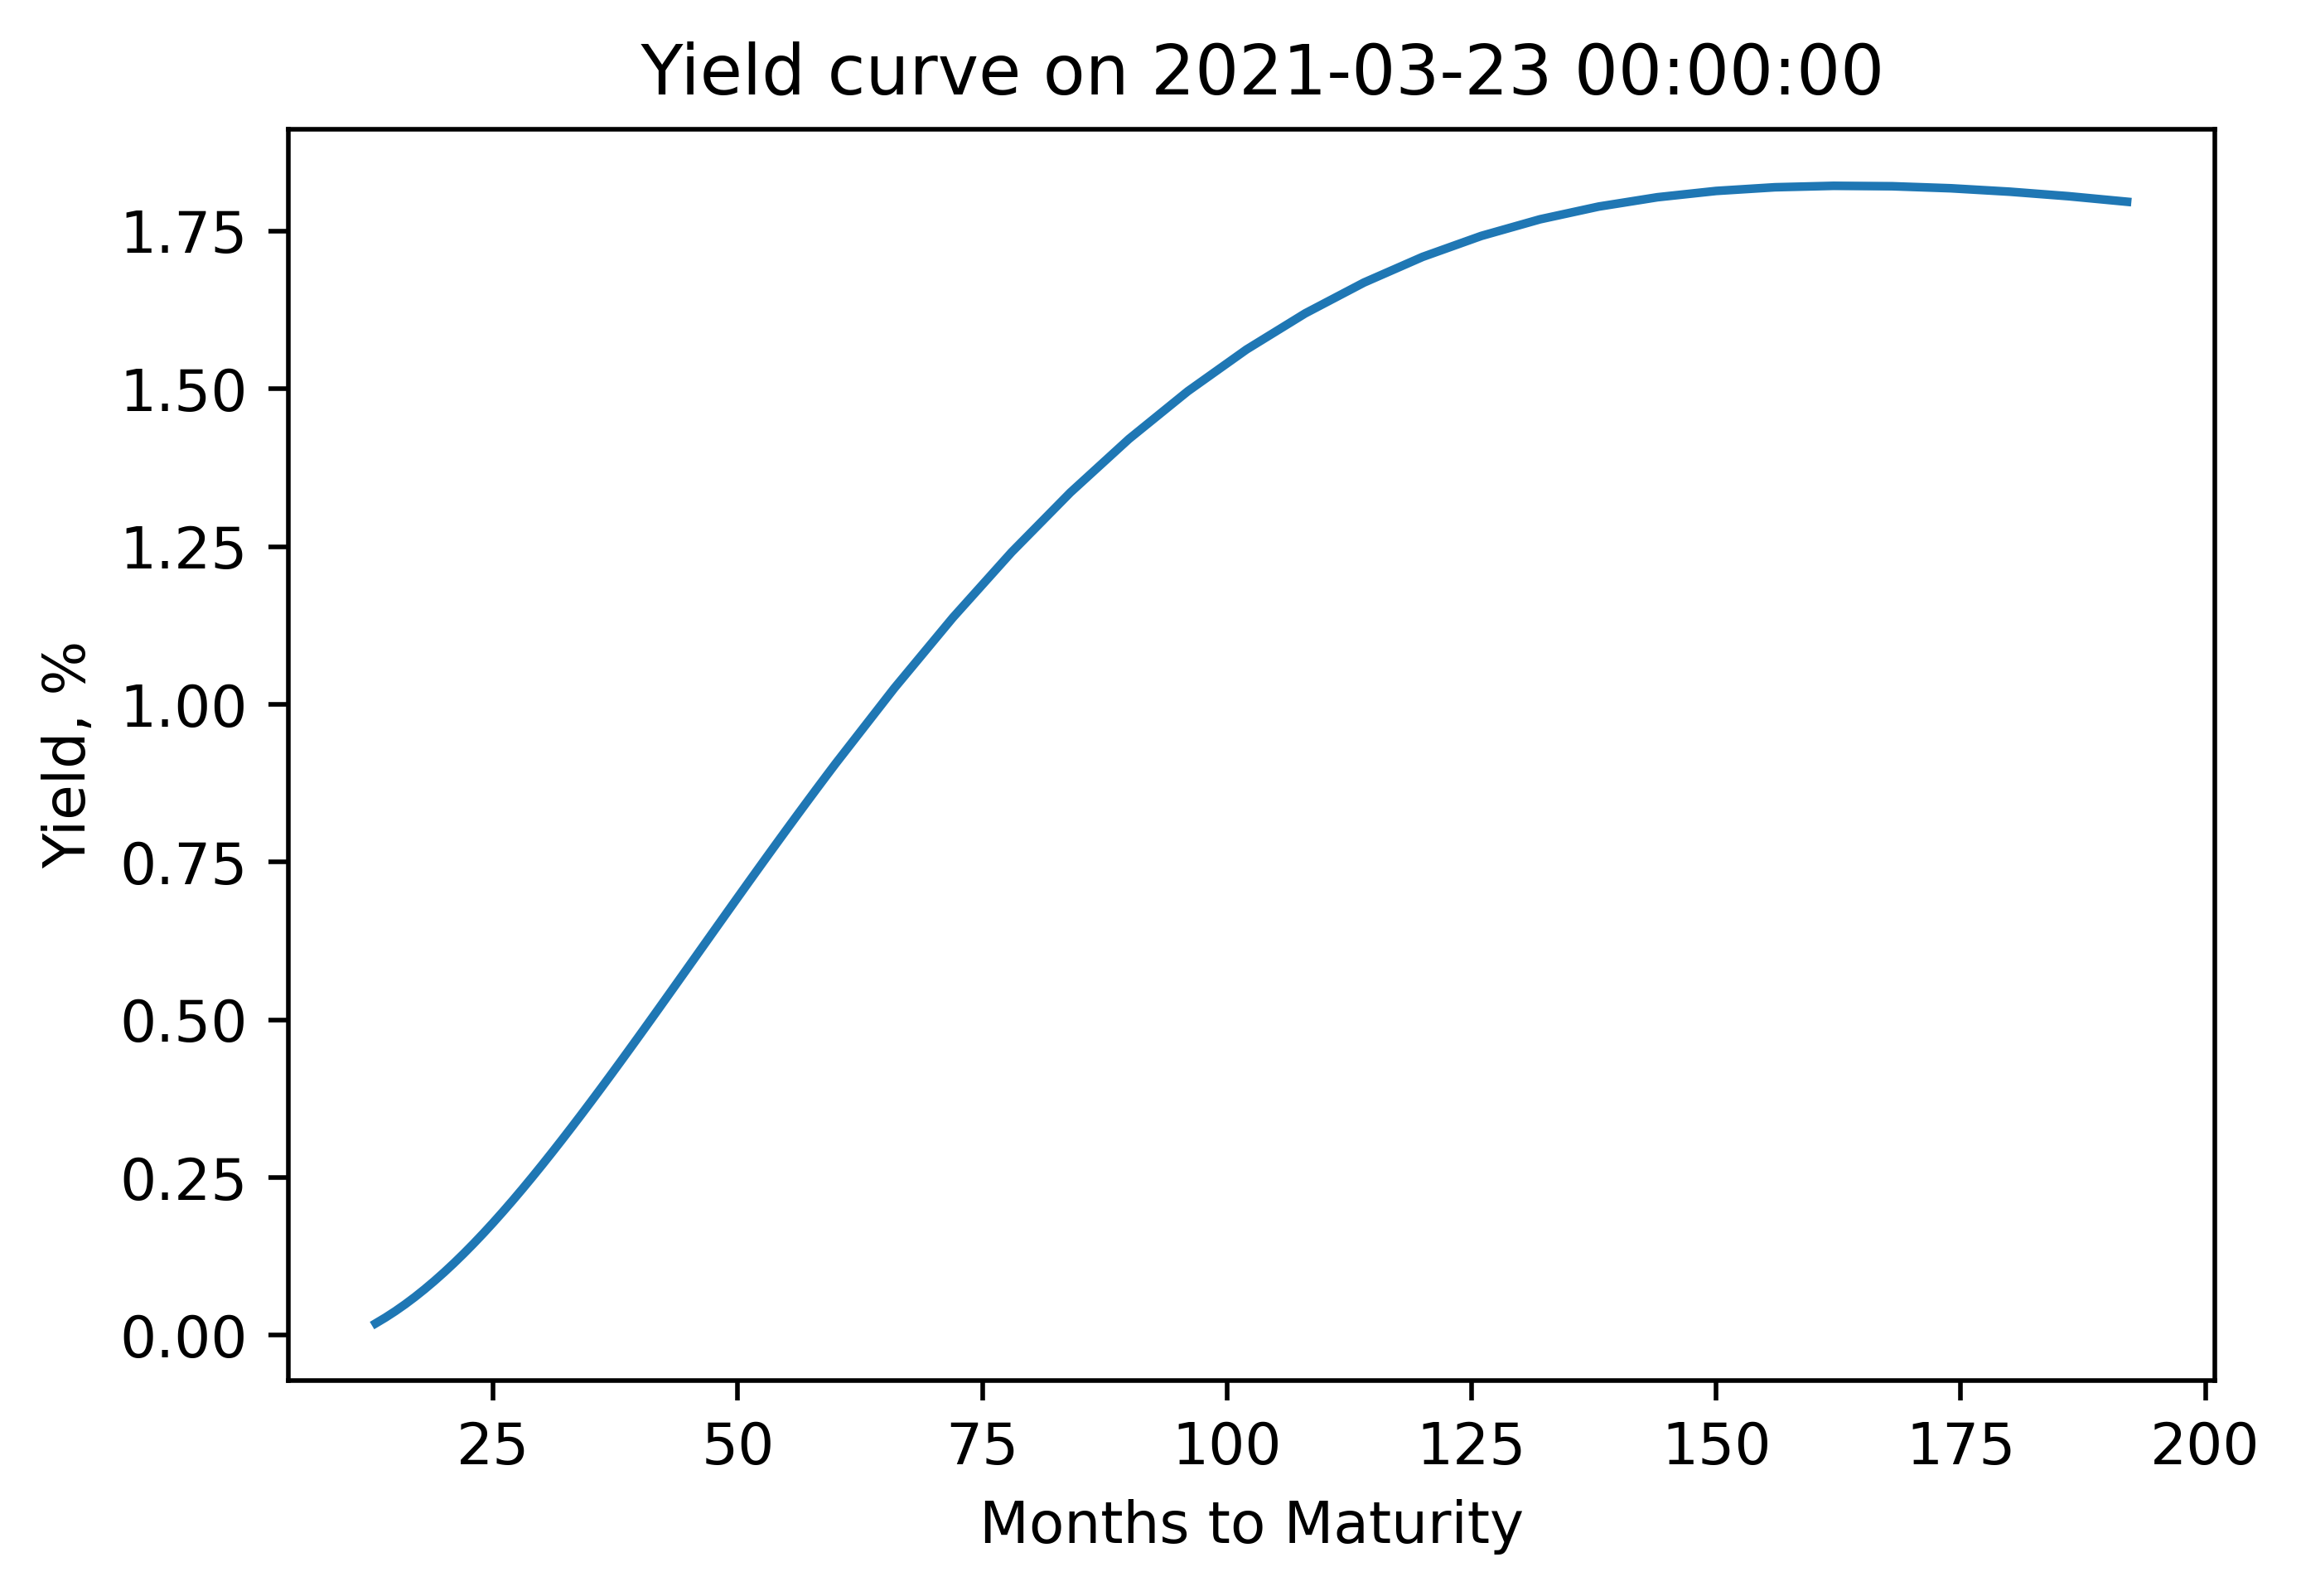

In [6]:
days_back = 300
my_df = df

fig, ax = plt.subplots(dpi=500)
ax.plot(my_df.columns, my_df.iloc[-days_back,:])
ax.set_ylabel("Yield, %")
ax.set_xlabel("Months to Maturity")
ax.set_title(f" Yield curve on {my_df.iloc[-days_back,:].name}")
plt.show()

# Apply PCA

In [7]:
scaler = StandardScaler()
df_std = scaler.fit_transform(df)
df_std = pd.DataFrame(df_std, columns=df.columns, index=df.index)

In [8]:
cov_mat = np.corrcoef(df_std.T)

In [9]:
eigenvalues, eigenvectors = np.linalg.eig(cov_mat)
eigenvalues, eigenvectors = eigenvalues.real, eigenvectors.real

In [10]:
# Put data into a DataFrame
df_eigval = pd.DataFrame({"Eigenvalues": eigenvalues})

# Find explained proportion 
df_eigval["Explained variance pct"] = df_eigval["Eigenvalues"] / np.sum(df_eigval["Eigenvalues"])

# Format as percentage
df_eigval['Explained variance pct'] = df_eigval["Explained variance pct"] * 100

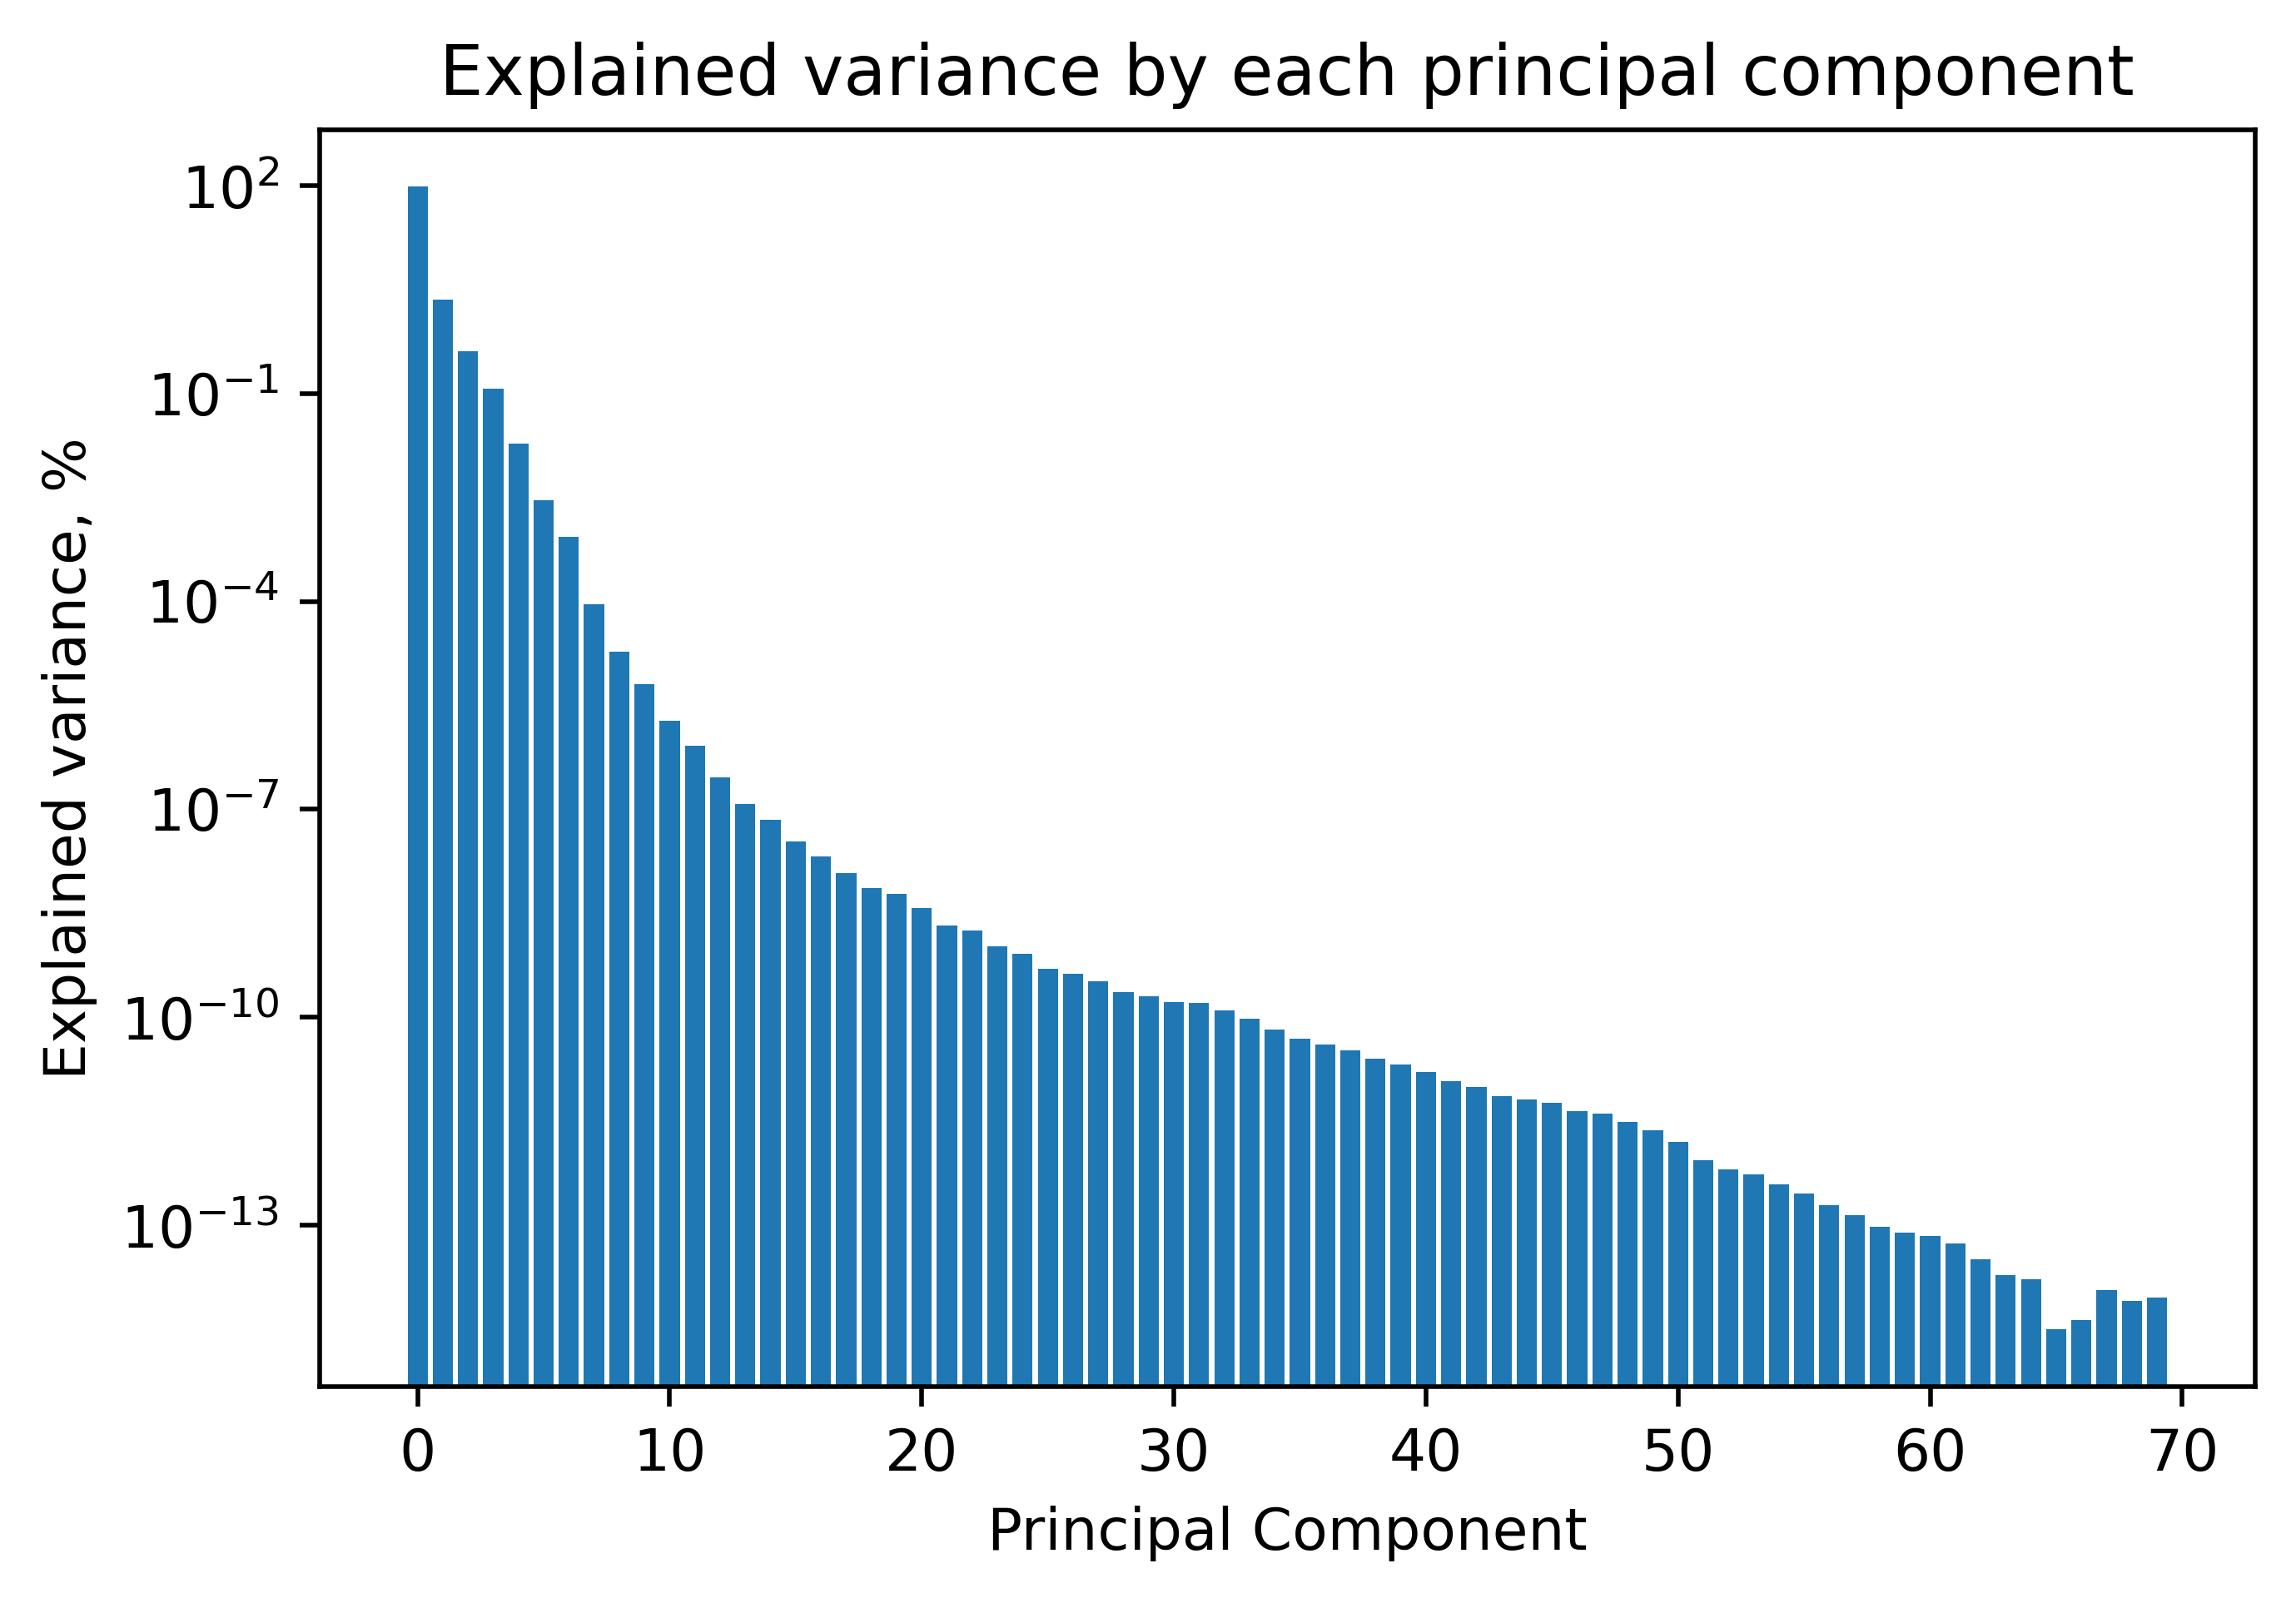

In [11]:
fig, ax = plt.subplots(dpi=500)
ax.bar(df_eigval.index, df_eigval['Explained variance pct'])
ax.set_yscale('log')
# ax.set_xticks(df_eigval.index)
# ax.set_xticklabels(df_eigval.index)
ax.set_title('Explained variance by each principal component')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained variance, %')
plt.show()

# Compare components with properties of the curve

In [12]:
# get projections onto components
projections = df_std.dot(eigenvectors)

In [13]:
# number of months
curve_start = 24
curve_middle = 60
curve_end = 120

selected_maturities = [curve_start, curve_middle, curve_end]

df_s = pd.DataFrame(data=df, columns=df.columns, index=df.index)
df_s = df_s[selected_maturities]
df_s["slope"] = df_s[curve_end] - df_s[curve_start]
df_s["curvature"] = df_s[curve_end] - 2*df_s[curve_middle] + df_s[curve_start]
df_s.head()

,24,60,120,slope,curvature
1979-01-02,12.752366,12.975944,12.343822,-0.408544,-0.855700
1979-01-03,12.765729,13.028611,12.365891,-0.399838,-0.925602
1979-01-04,12.680559,13.021113,12.348660,-0.331899,-1.013006
1979-01-05,12.631572,13.068732,12.438259,-0.193313,-1.067634
1979-01-08,12.600416,13.071943,12.443538,-0.156878,-1.099932


##### Compute correlations between PCA components and features of yield curve

In [14]:
corr_level = np.corrcoef(projections[0], df_s[curve_end])[0, 1]
corr_slope = np.corrcoef(projections[1], df_s['slope'])[0, 1]
corr_curva = np.corrcoef(projections[2], df_s['curvature'])[0, 1]

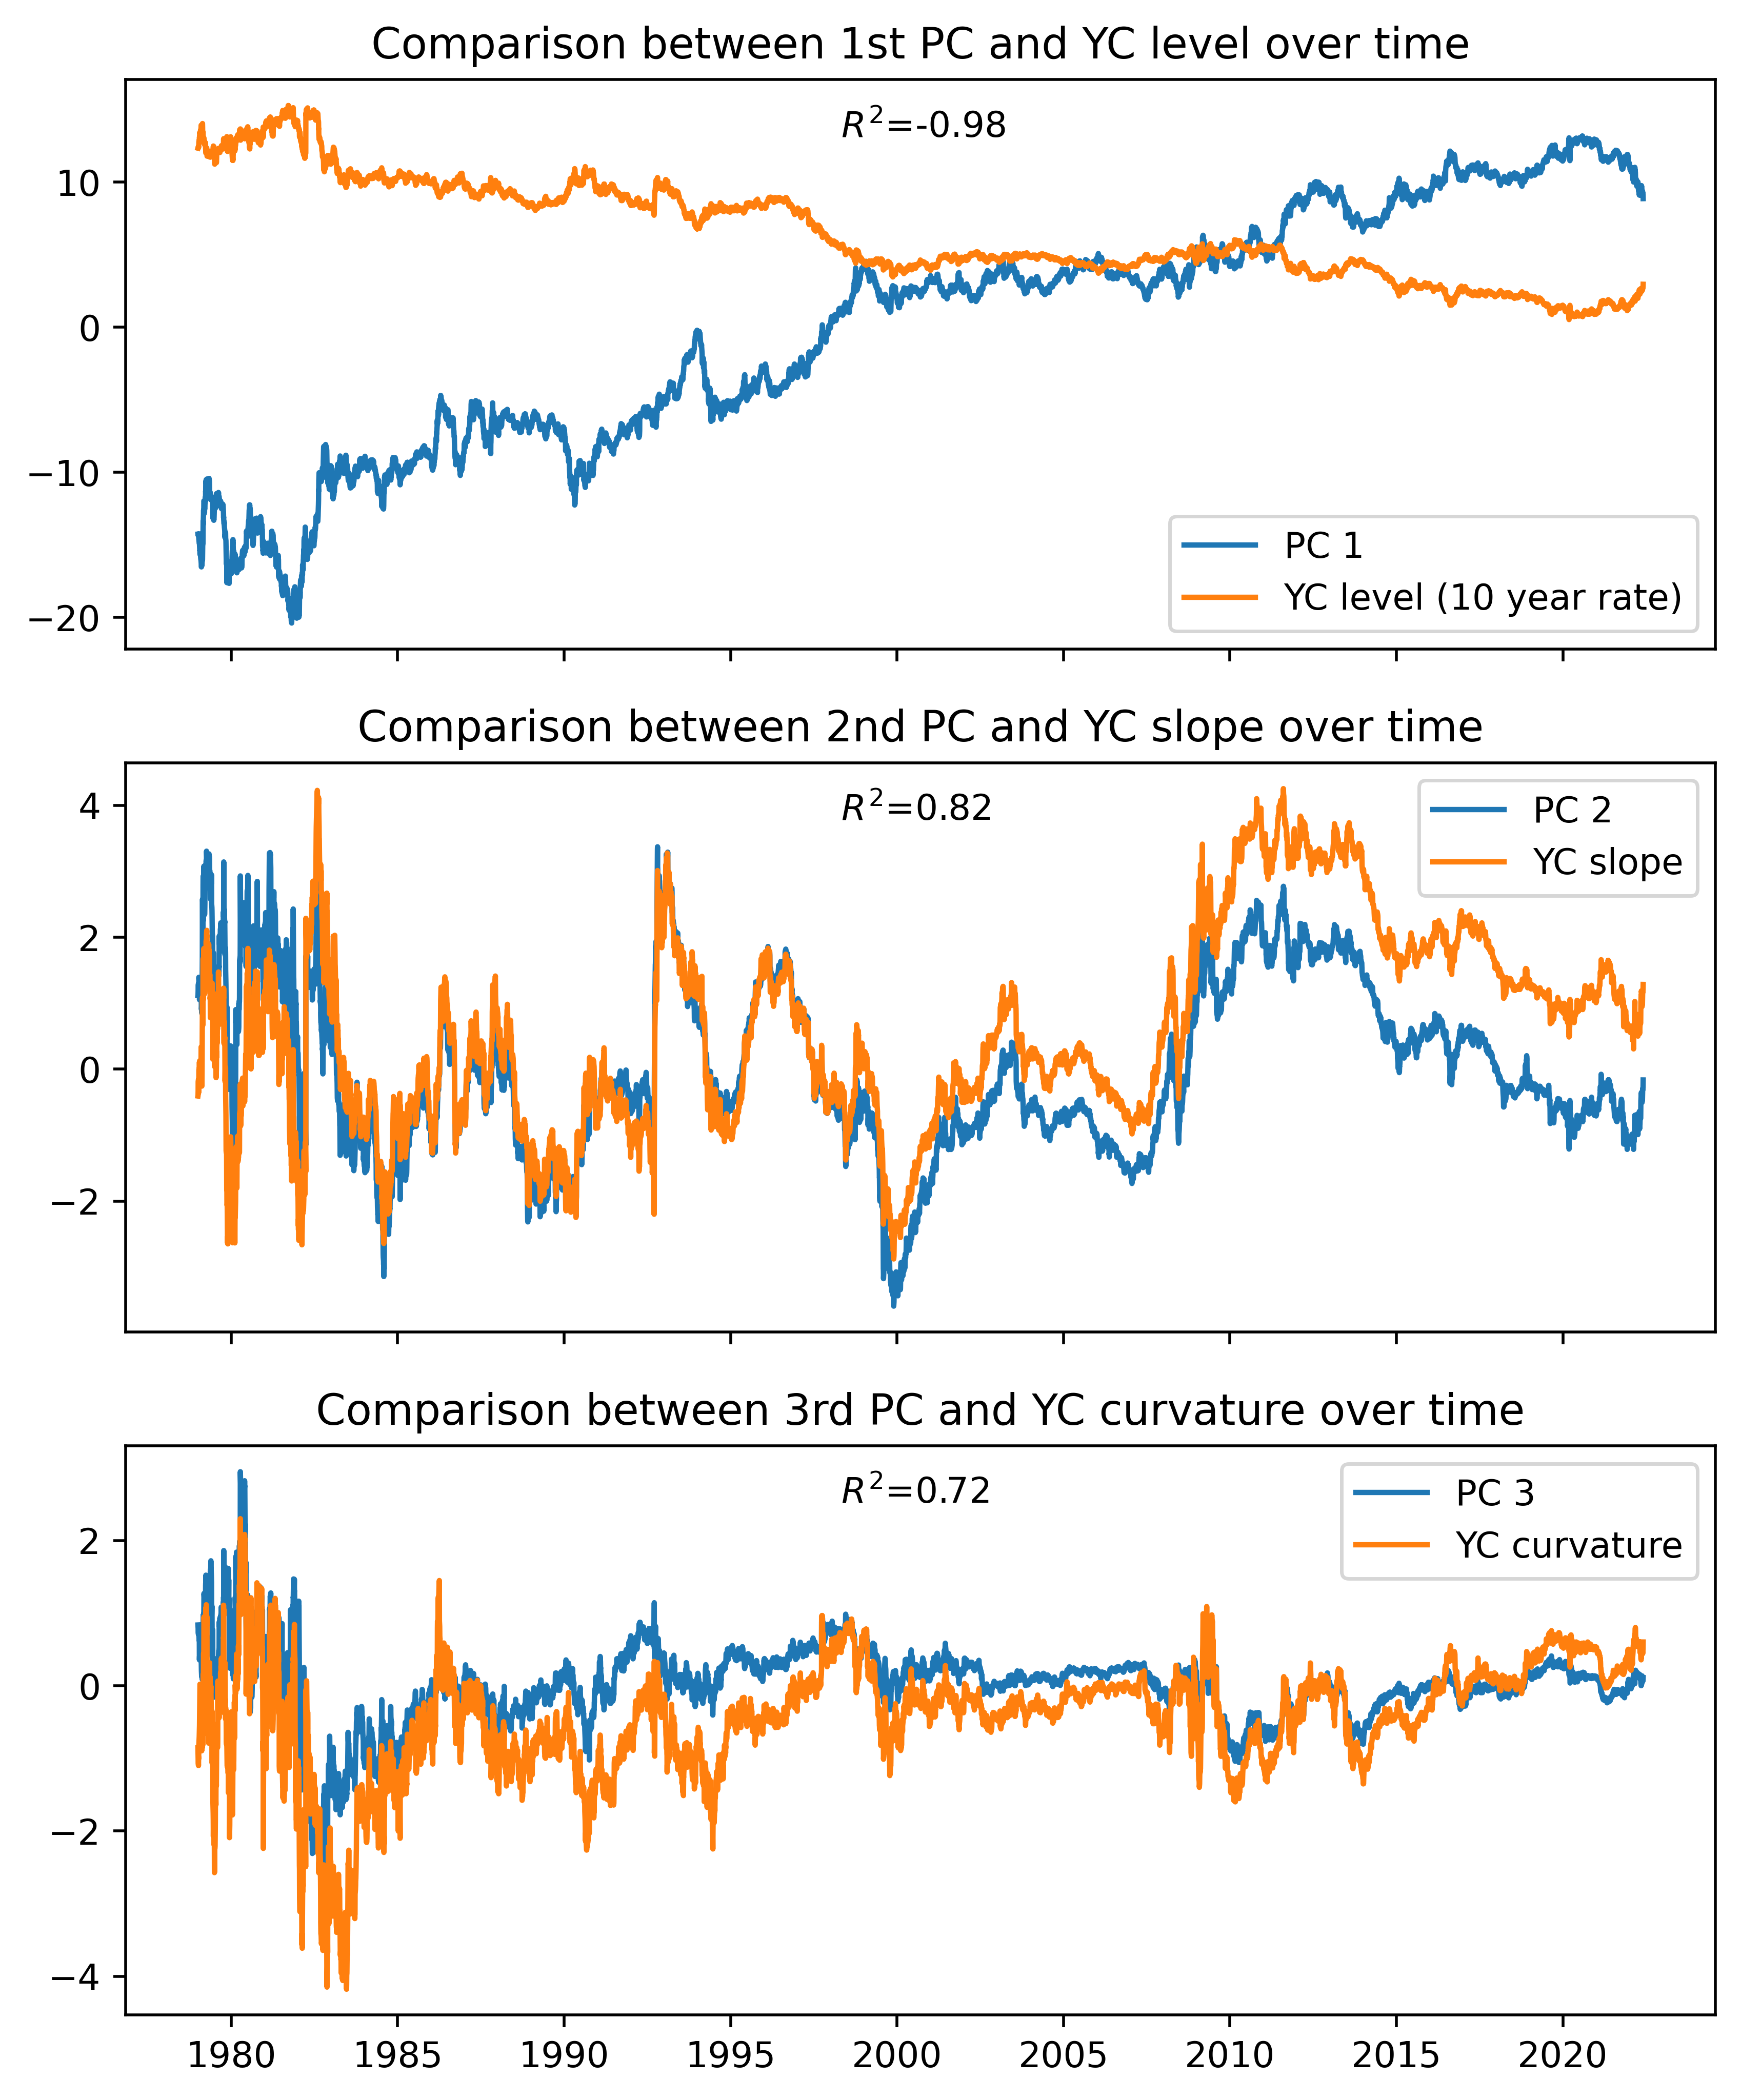

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10), dpi=500, sharex=True)

ax1.plot(projections.index, projections[0], label="PC 1")
ax1.plot(df.index, df[curve_end], label="YC level (10 year rate)")
ax1.set_title("Comparison between 1st PC and YC level over time")
ax1.annotate(r'$R^2$={:.2f}'.format(corr_level), xy=(0.45, 0.9), xycoords='axes fraction')
ax1.legend()

ax2.plot(projections.index, projections[1], label="PC 2")
ax2.plot(df_s.index, df_s['slope'], label="YC slope")
ax2.set_title("Comparison between 2nd PC and YC slope over time")
ax2.annotate(r'$R^2$={:.2f}'.format(corr_slope), xy=(0.45, 0.9), xycoords='axes fraction')
ax2.legend()

ax3.plot(projections.index, projections[2], label="PC 3")
ax3.plot(df_s.index, df_s['curvature'], label="YC curvature")
ax3.set_title("Comparison between 3rd PC and YC curvature over time")
ax3.annotate(r'$R^2$={:.2f}'.format(corr_curva), xy=(0.45, 0.9), xycoords='axes fraction')
ax3.legend()

plt.show()

# Fit prices curve

In [16]:
prices_df = 100 - df
maturities = [float(x) for x in prices_df.columns]

In [17]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

num_components = 3
top_components = projections.iloc[:, :3]

X = top_components

# poly_degree = 2
# method 1: create powers of data
# X_poly = np.hstack([X**(i+1) for i in range(poly_degree)])

# method 2: powers of data  (contains interaction terms eg x_1*x_2)
# poly = PolynomialFeatures(degree=poly_degree, include_bias=False)
# X_poly = poly.fit_transform(X)

# method 3: similar to method 1, contains 0th power
# X_poly = np.power(X, np.arange(poly_degree+1)) 

# coefs, residuals, rank, sing_vals, rcond = np.polyfit(x=top_components.T.values,
#                                                       y=prices_df.T.values, deg=2, full=True)

all_curves = []
all_resids = []
all_coefs = []
curves = []
for i in range(len(maturities)):

    y = prices_df.iloc[:, i]
    poly_reg_model = LinearRegression()
    
    poly_reg_model.fit(X, y)
    y_pred = poly_reg_model.predict(X)
    
    coefs, intercept = poly_reg_model.coef_, poly_reg_model.intercept_
    
    all_coefs.append(coefs)
    curves.append(y_pred)

curves_pred_df = pd.DataFrame(curves, columns=prices_df.index, index=prices_df.columns).T
residuals_df = curves_pred_df - prices_df


In [18]:
coefs_df = pd.DataFrame(all_coefs, columns=['beta_1', 'beta_2', 'beta_3'], index=prices_df.columns)
covariance_df = pd.DataFrame(np.cov(X.T), index=['beta_1', 'beta_2', 'beta_3'], columns=['beta_1', 'beta_2', 'beta_3'])
# covariance_df = pd.DataFrame(np.cov(prices_df.values.T), index=prices_df.columns, columns=prices_df.columns)

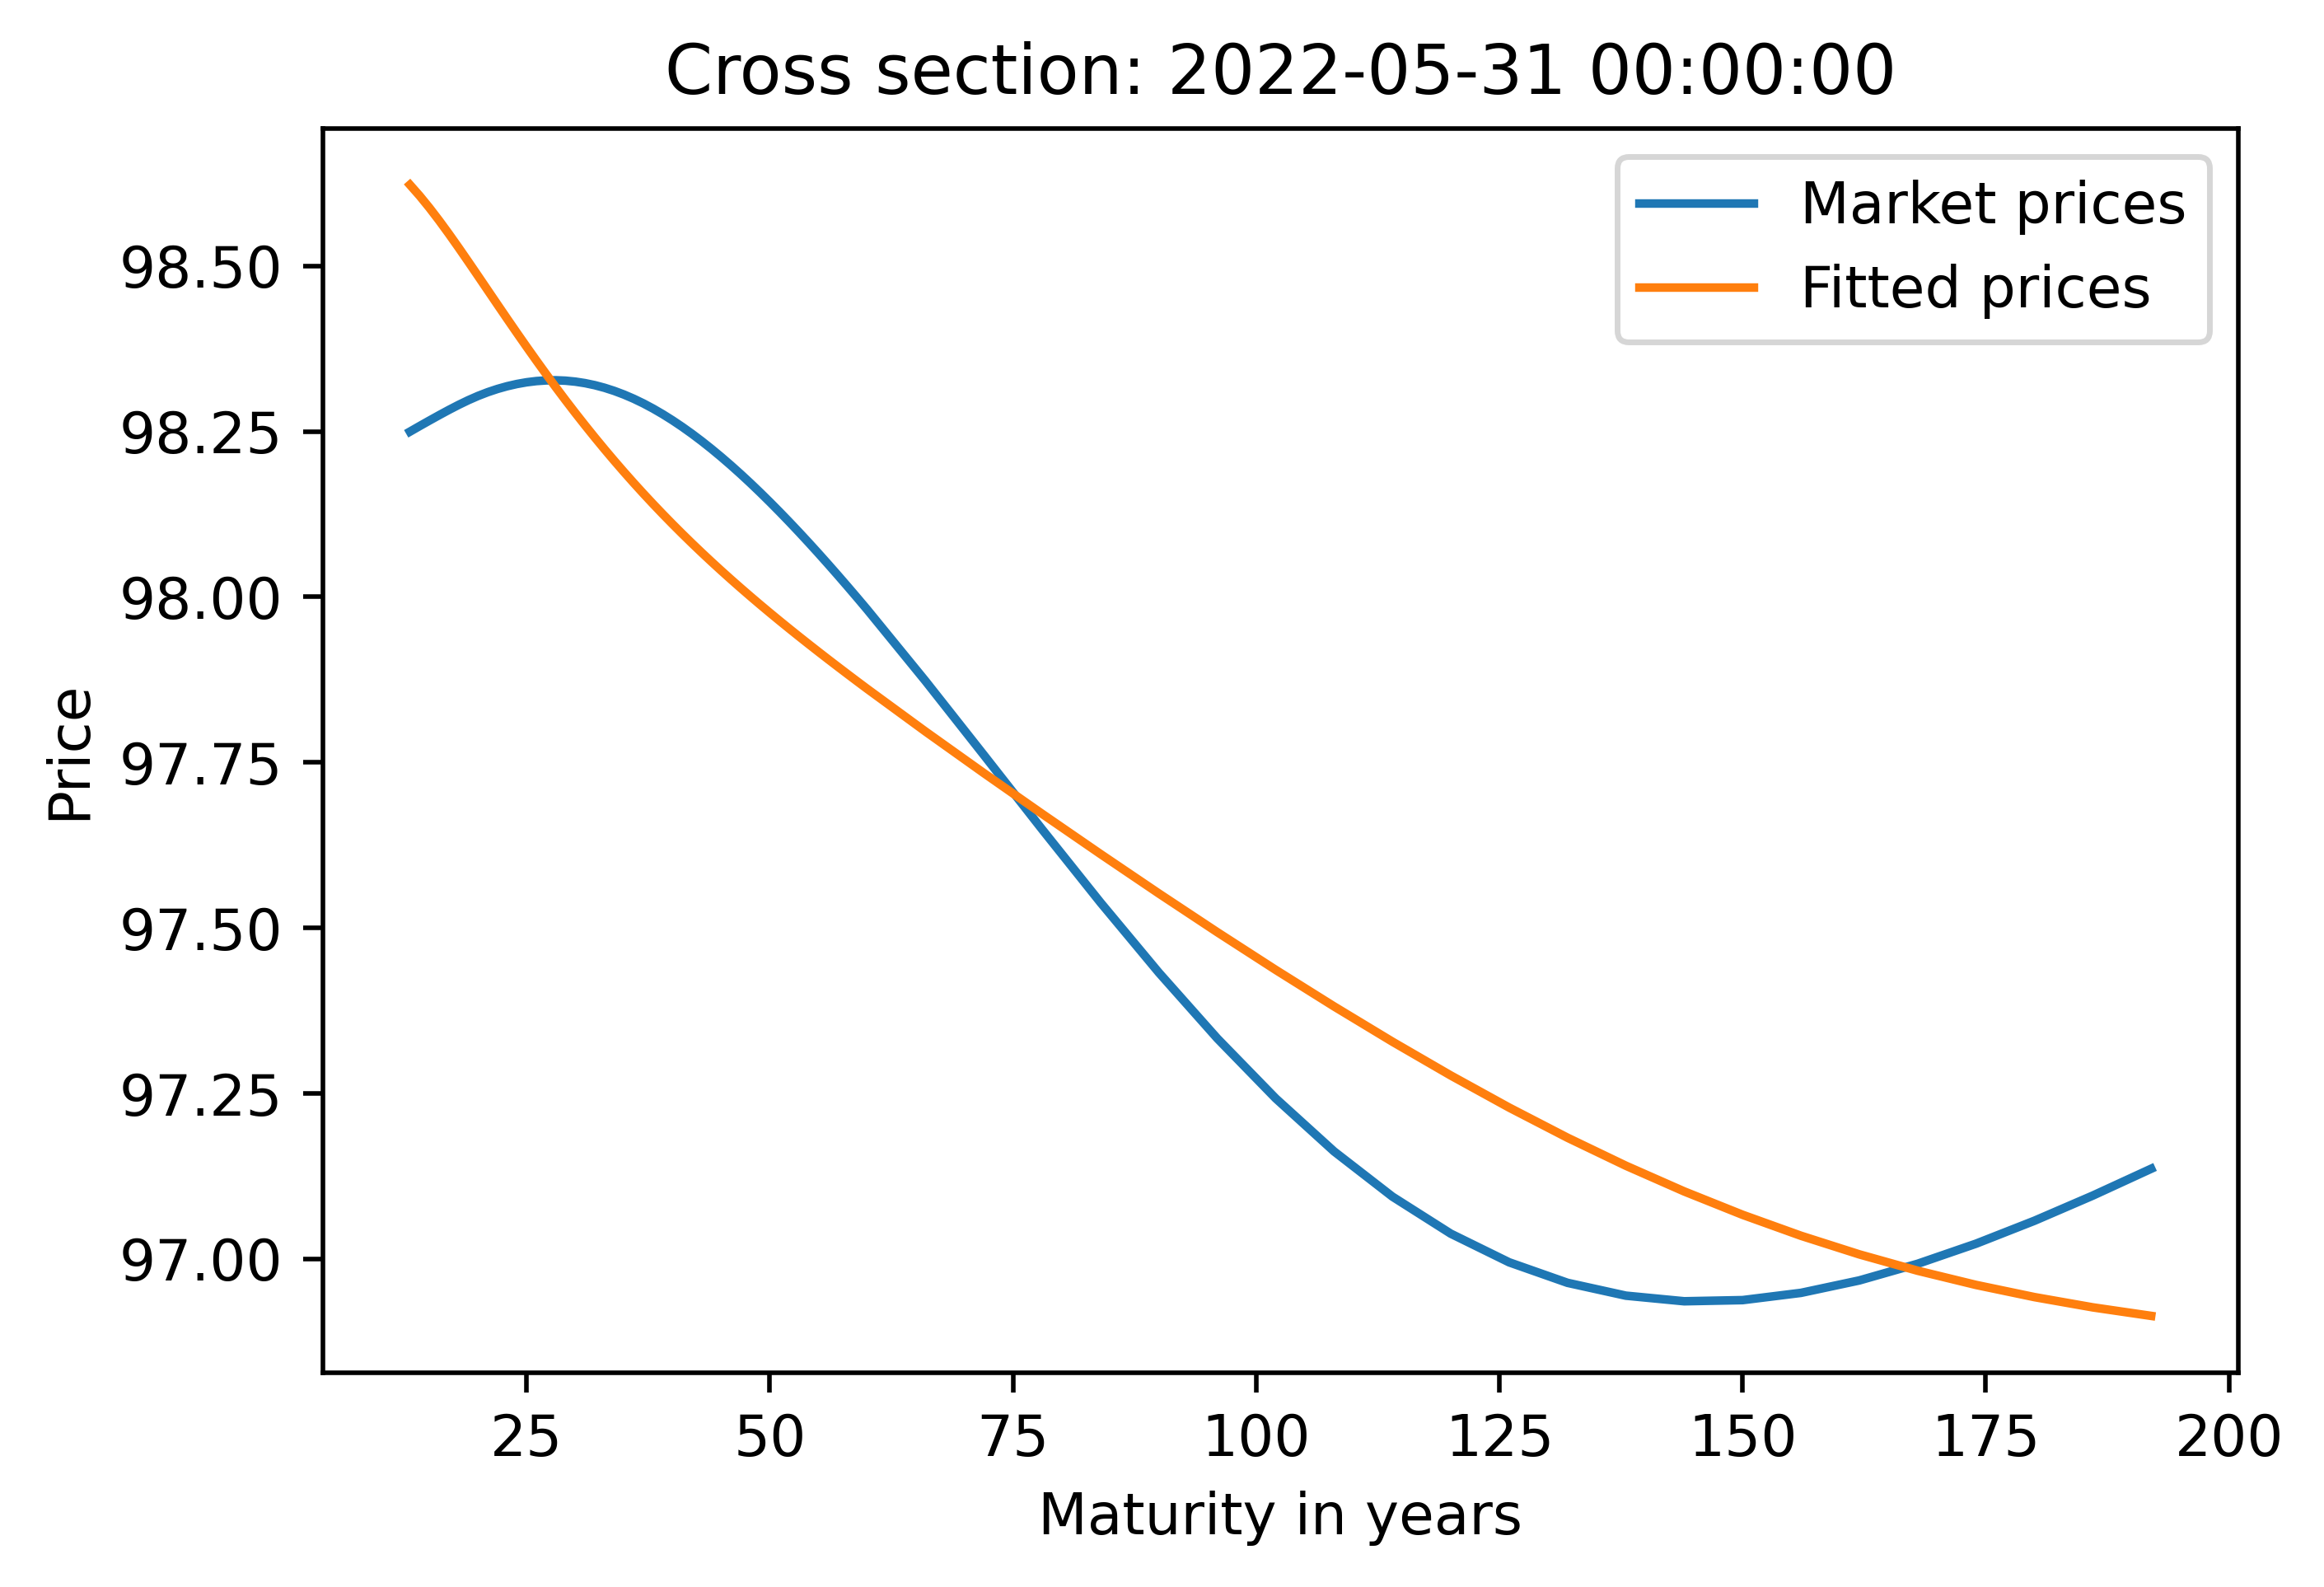

In [19]:
fig, ax = plt.subplots(figsize = (6, 4), dpi=500)
days_back=1
ax.plot(prices_df.columns, prices_df.iloc[-days_back, :], label="Market prices")
ax.plot(curves_pred_df.columns, curves_pred_df.iloc[-days_back, :], label="Fitted prices")
ax.set_title(f"Cross section: {curves_pred_df.iloc[-days_back, :].name}")

ax.set_xlabel("Maturity in years")
ax.set_ylabel("Price")
plt.legend()
plt.show()


##### Plot residual of curve fit for selected maturities

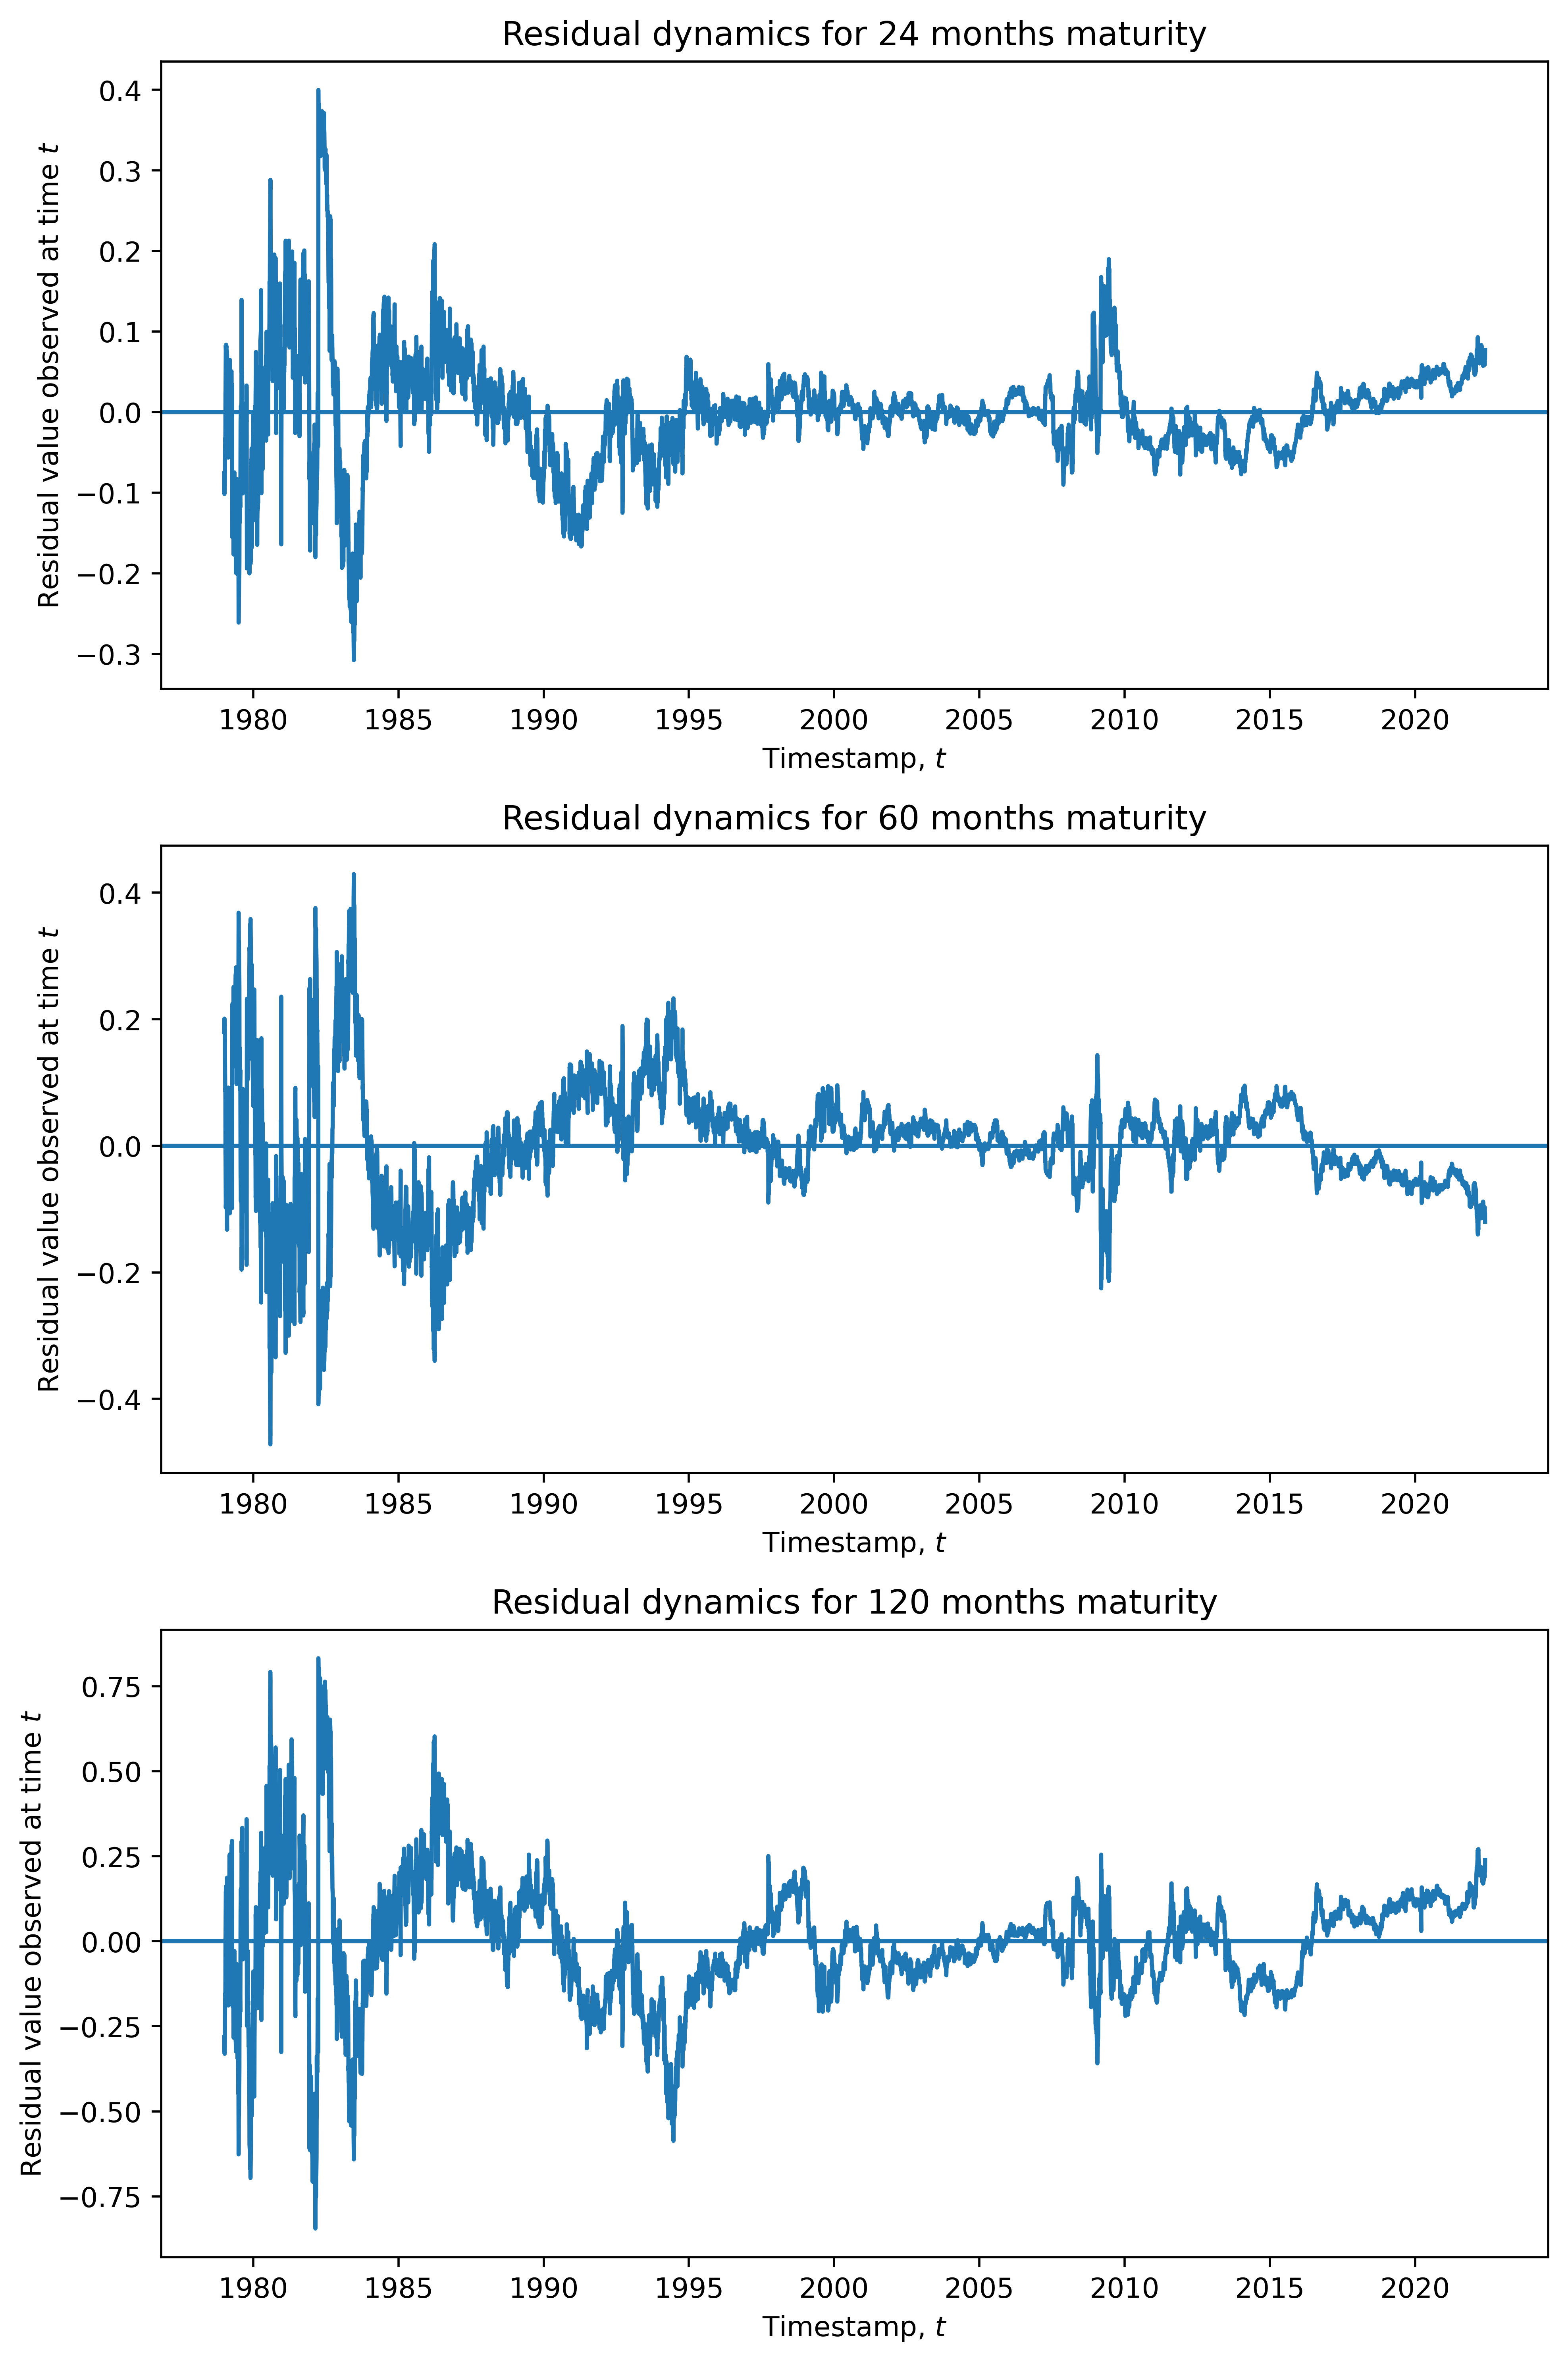

In [20]:
fig, axs = plt.subplots(len(selected_maturities), 1, figsize=(8, 12), dpi=500)

counter_mat = 0
for i in range(len(axs)):
    
    my_mat = selected_maturities[counter_mat]
    counter_mat = counter_mat + 1
    
    ax=axs[i]
    ax.plot(residuals_df[my_mat].index, residuals_df[my_mat].values)
    ax.axhline(0)
    
    ax.set_xlabel("Timestamp, $t$")
    ax.set_ylabel("Residual value observed at time $t$")
    ax.set_title(f"Residual dynamics for {my_mat} months maturity")

fig.tight_layout()
plt.show()

# Portfolio

##### Optimise portfolio by calculating Bid/Ask quotes that maximise risk-return and making trades

In [21]:
cash = 1_000_000
trades = 0
quantity = 1
value = [cash]

utility_t = []
cross_risk_t = []
contract_risk_t = []
value_increment_t = []
risk_increment_t = []
bid_diffs = []
ask_diffs = []
bid_limit_t = []
ask_limit_t = []


ptf_pos = np.random.randint(-3, 3, len(prices_df.columns))
ptf_wgts = ptf_pos / np.sum(np.abs(ptf_pos))

pi_1 = 1
pi_2 = 1
risk_matrix = pi_1 * (coefs_df.values @ covariance_df.values @ coefs_df.values.T + 
                      pi_2 * np.identity(coefs_df.shape[0]))


for date in range(len(prices_df)):
    for contract in range(len(prices_df.columns)):
        contract_vector = np.zeros(len(prices_df.columns))
        contract_vector[contract] = 1
        z_scores = residuals_df.iloc[date, :].values
        
        # find contract price and estimated fair price
        contract_price = prices_df.iloc[date, contract]
        fair_price = curves_pred_df.iloc[date, contract]
        
        # calculate risk terms from adding new contract to portfolio
        cross_risk = 2 * contract_vector.T @ risk_matrix @ ptf_pos
        # cross_risk = 2 * contract_vector.T @ risk_matrix @ ptf_wgts
        contract_risk = contract_vector.T @ risk_matrix @ contract_vector
        
        # calculate bid and ask limits at which we are willing to trade
        bid_limit = fair_price - cross_risk - contract_risk
        ask_limit = fair_price - cross_risk + contract_risk
        
        if  contract_price < bid_limit:
            ptf_pos[contract] += quantity
            cash -= contract_price * quantity
            trades += 1
            
            # calcualte value and risk increments added to portfolio if we trade
            value_increment = quantity * (fair_price - contract_price)
            risk_increment = quantity * (cross_risk + quantity * contract_risk)
            risk_matrix = np.add(risk_matrix, risk_increment)
            
            # track variables
            value.append(value[-1] + value_increment)
            value_increment_t.append(value_increment)
            risk_increment_t.append(risk_increment)
            
        elif contract_price > ask_limit:
            ptf_pos[contract] -= quantity
            cash += contract_price * quantity
            trades += 1
    
            # calcualte value and risk increments added to portfolio if we trade
            value_increment = -quantity * (fair_price - contract_price)
            risk_increment = -quantity * (cross_risk - quantity * contract_risk)
            risk_matrix = np.add(risk_matrix , risk_increment)
            
            # track variables
            value.append(value[-1] + value_increment)
            value_increment_t.append(value_increment)
            risk_increment_t.append(risk_increment)

        else:
            value.append(value[-1])
            value_increment_t.append(np.nan)
            risk_increment_t.append(np.nan)
        
        # track variables
        cross_risk_t.append(cross_risk)
        contract_risk_t.append(contract_risk)
        bid_diffs.append(bid_limit - contract_price)
        ask_diffs.append(ask_limit - contract_price)
        bid_limit_t.append(bid_limit)
        ask_limit_t.append(ask_limit)
        utility_t.append(z_scores.T.dot(ptf_pos) - ptf_pos.T.dot(risk_matrix).dot(ptf_pos))
        

    
    print(f'DATE: {prices_df.index.to_series().iloc[date]}, TRADES: {trades}, VALUE: {value[-1]}') # , end="\r", flush=True)

DATE: 1979-01-02 00:00:00, TRADES: 70, VALUE: 999999.3135269458
DATE: 1979-01-03 00:00:00, TRADES: 135, VALUE: 1000000.2769685744
DATE: 1979-01-04 00:00:00, TRADES: 135, VALUE: 1000000.2769685744
DATE: 1979-01-05 00:00:00, TRADES: 135, VALUE: 1000000.2769685744
DATE: 1979-01-08 00:00:00, TRADES: 135, VALUE: 1000000.2769685744
DATE: 1979-01-09 00:00:00, TRADES: 135, VALUE: 1000000.2769685744
DATE: 1979-01-10 00:00:00, TRADES: 135, VALUE: 1000000.2769685744
DATE: 1979-01-11 00:00:00, TRADES: 135, VALUE: 1000000.2769685744
DATE: 1979-01-12 00:00:00, TRADES: 135, VALUE: 1000000.2769685744
DATE: 1979-01-15 00:00:00, TRADES: 135, VALUE: 1000000.2769685744
DATE: 1979-01-16 00:00:00, TRADES: 135, VALUE: 1000000.2769685744
DATE: 1979-01-17 00:00:00, TRADES: 135, VALUE: 1000000.2769685744


/tmp/ipykernel_48612/3863353183.py:37: RuntimeWarning: overflow encountered in matmul
  cross_risk = 2 * contract_vector.T @ risk_matrix @ ptf_pos
/tmp/ipykernel_48612/3863353183.py:37: RuntimeWarning: invalid value encountered in matmul
  cross_risk = 2 * contract_vector.T @ risk_matrix @ ptf_pos


DATE: 1979-01-18 00:00:00, TRADES: 135, VALUE: 1000000.2769685744
DATE: 1979-01-19 00:00:00, TRADES: 135, VALUE: 1000000.2769685744
DATE: 1979-01-22 00:00:00, TRADES: 135, VALUE: 1000000.2769685744
DATE: 1979-01-23 00:00:00, TRADES: 135, VALUE: 1000000.2769685744
DATE: 1979-01-24 00:00:00, TRADES: 135, VALUE: 1000000.2769685744
DATE: 1979-01-25 00:00:00, TRADES: 135, VALUE: 1000000.2769685744
DATE: 1979-01-26 00:00:00, TRADES: 135, VALUE: 1000000.2769685744
DATE: 1979-01-29 00:00:00, TRADES: 135, VALUE: 1000000.2769685744
DATE: 1979-01-30 00:00:00, TRADES: 135, VALUE: 1000000.2769685744
DATE: 1979-01-31 00:00:00, TRADES: 135, VALUE: 1000000.2769685744
DATE: 1979-02-01 00:00:00, TRADES: 135, VALUE: 1000000.2769685744
DATE: 1979-02-02 00:00:00, TRADES: 135, VALUE: 1000000.2769685744
DATE: 1979-02-05 00:00:00, TRADES: 135, VALUE: 1000000.2769685744
DATE: 1979-02-06 00:00:00, TRADES: 135, VALUE: 1000000.2769685744
DATE: 1979-02-07 00:00:00, TRADES: 135, VALUE: 1000000.2769685744
DATE: 1979

In [22]:
x=1